> **Problem overview**

This challenge serves as final project for the "How to win a data science competition" Coursera course. In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

In [1]:
# import python standard library
import gc, itertools

# import data manipulation library
import numpy as np
import pandas as pd

# import data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import sklearn data preprocessing
from sklearn.preprocessing import LabelEncoder

# import xgboost model class
import xgboost as xgb

# import sklearn model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# import sklearn model evaluation regression metrics
from sklearn.metrics import mean_squared_error

In [2]:
# pandas options
pd.options.display.max_rows = 10

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [3]:
# acquiring training and testing data
df_train = pd.read_csv('../input/sales_train.csv')
df_test = pd.read_csv('../input/test.csv')

In [4]:
# acquiring supplemental information
df_items = pd.read_csv('../input/items.csv')
df_categories = pd.read_csv('../input/item_categories.csv')
df_shops = pd.read_csv('../input/shops.csv')

In [5]:
# visualize head of the training data
df_train.head(n=5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
# visualize tail of the testing data
df_test.tail(n=5)

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


In [7]:
# visualize head of the supplemental information about the items/products
df_items.head(n=5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
# visualize head of the supplemental information about the items categories
df_categories.head(n=5)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
# visualize head of the supplemental information about the shops
df_shops.head(n=5)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
# combine training and testing dataframe
df_train['datatype'], df_test['datatype'] = 'training', 'testing'
df_train.insert(0, 'ID', np.nan)
df_test.insert(1, 'date', '01.11.2015')
df_test.insert(2, 'date_block_num', 34)
df_test.insert(df_test.shape[1] - 1, 'item_price', np.nan)
df_test.insert(df_test.shape[1] - 1, 'item_cnt_day', np.nan)
df_data = pd.concat([df_train, df_test], ignore_index=False)

> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [11]:
# countplot function plot - categorical variable (x-axis) vs. categorical variable (y-axis)
def countplot(x = None, y = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i, v in enumerate(x): sns.countplot(x=v, hue=y, data=data, ax=axes[i])

In [12]:
# boxplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def boxplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.boxplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.boxplot(x=cat, y=v, data=data, ax=axes[i])

In [13]:
# boxplot function sorted plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def boxplotsort(cat = None, num = None, data = None, ncols = 5, nrows = 3, orderby='median'):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.boxplot(x=v, y=num, data=data, ax=axes[i], order=data.groupby([v], as_index=True).agg({num: orderby}).sort_values(num).index)
    else:
        for i, v in enumerate(num): sns.boxplot(x=cat, y=v, data=data, ax=axes[i], order=data.groupby([cat], as_index=True).agg({v: orderby}).sort_values(v).index)

In [14]:
# swarmplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def swarmplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.swarmplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.swarmplot(x=cat, y=v, data=data, ax=axes[i])

In [15]:
# violinplot function plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def violinplot(cat = None, num = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.violinplot(x=v, y=num, data=data, ax=axes[i])
    else:
        for i, v in enumerate(num): sns.violinplot(x=cat, y=v, data=data, ax=axes[i])

In [16]:
# violinplot function sorted plot - categorical variable (x-axis) vs. numerical variable (y-axis)
def violinplotsort(cat = None, num = None, data = None, ncols = 5, nrows = 3, orderby='median'):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    if type(cat) == list:
        for i, v in enumerate(cat): sns.violinplot(x=v, y=num, data=data, ax=axes[i], order=data.groupby([v], as_index=True).agg({num: orderby}).sort_values(num).index)
    else:
        for i, v in enumerate(num): sns.violinplot(x=cat, y=v, data=data, ax=axes[i], order=data.groupby([cat], as_index=True).agg({v: orderby}).sort_values(v).index)

In [17]:
# scatterplot function plot - numerical variable (x-axis) vs. numerical variable (y-axis)
def scatterplot(x = None, y = None, data = None, ncols = 5, nrows = 3):
    fig, axes = plt.subplots(figsize=(4*ncols , 3*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    for i, xi in enumerate(x): sns.scatterplot(x=xi, y=y, data=data, ax=axes[i])

In [18]:
# describe training and testing data
df_data.describe(include='all')

,ID,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,datatype
count,214200.00,3150049,3.150049e+06,3.150049e+06,3.150049e+06,2.935849e+06,2.935849e+06,3150049
unique,NaN,1035,NaN,NaN,NaN,NaN,NaN,2
top,NaN,01.11.2015,NaN,NaN,NaN,NaN,NaN,training
freq,NaN,214200,NaN,NaN,NaN,NaN,NaN,2935849
mean,107099.50,NaN,1.589114e+01,3.290933e+01,1.025313e+04,8.908532e+02,1.242641e+00,NaN
...,...,...,...,...,...,...,...,...
min,0.00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,NaN
25%,53549.75,NaN,7.000000e+00,2.200000e+01,4.510000e+03,2.490000e+02,1.000000e+00,NaN
50%,107099.50,NaN,1.500000e+01,3.100000e+01,9.461000e+03,3.990000e+02,1.000000e+00,NaN
75%,160649.25,NaN,2.400000e+01,4.700000e+01,1.572700e+04,9.990000e+02,1.000000e+00,NaN


In [19]:
# list all features type number
col_number = df_data.select_dtypes(include=['number']).columns.tolist()
print('features type number:\n items %s\n length %d' %(col_number, len(col_number)))

# list all features type object
col_object = df_data.select_dtypes(include=['object']).columns.tolist()
print('features type object:\n items %s\n length %d' %(col_object, len(col_object)))

features type number:
 items ['ID', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']
 length 6
features type object:
 items ['date', 'datatype']
 length 2


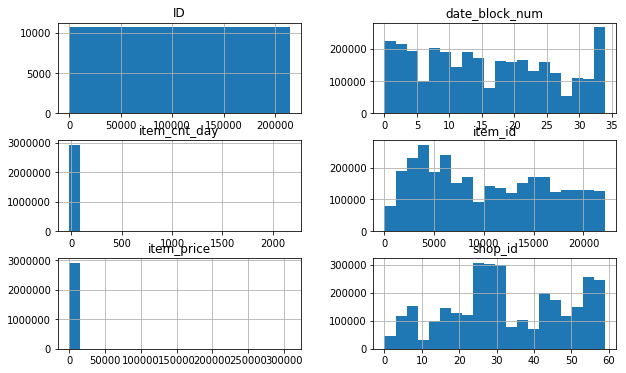

In [20]:
# feature exploration: histogram of all numeric features
_ = df_data.hist(bins=20, figsize=(10, 6))

In [21]:
# feature extraction: fix the duplicated shop id
df_data.loc[df_data['shop_id'] == 0, 'shop_id'] = 57
df_data.loc[df_data['shop_id'] == 1, 'shop_id'] = 58
df_data.loc[df_data['shop_id'] == 11, 'shop_id'] = 10

In [22]:
# feature extraction: set maximum and minimum limit for item price
df_data = df_data[((df_data['item_price'] >= 0) & (df_data['item_price'] <= 100000)) | (df_data['item_price'].isna())]
df_data['item_price'] = np.log1p(df_data['item_price'])

In [23]:
# feature extraction: set maximum and minimum limit for number of products sold
df_data = df_data[((df_data['item_cnt_day'] >= 0) & (df_data['item_cnt_day'] <= 1000)) | (df_data['item_cnt_day'].isna())]

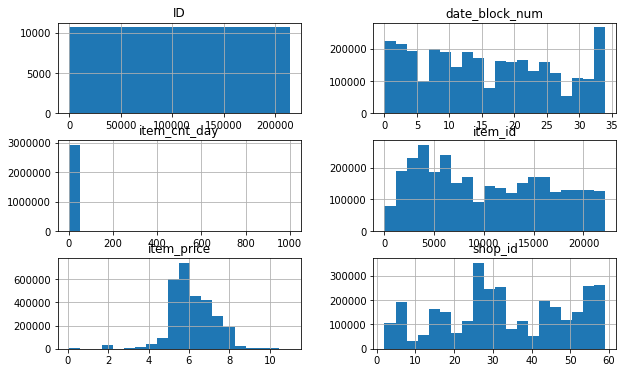

In [24]:
# feature exploration: histogram of all numeric features
_ = df_data.hist(bins=20, figsize=(10, 6))

In [25]:
# feature exploration: zero number of products sold
df_data[df_data['item_cnt_day'] == 0].head()

,ID,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,datatype


The exploratory data analysis resulting in,

* **Number of products sold:** There is no data for zero number of products sold. It is required to create the cross table of zero number of products sold in each month and merge to the main dataframe.

In [26]:
# feature extraction: cross dataframe
list_of_cross, months = [], df_data['date_block_num'].unique()
for month in months:
    shops = df_data.loc[df_data['date_block_num'] == month, 'shop_id'].unique()
    items = df_data.loc[df_data['date_block_num'] == month, 'item_id'].unique()
    list_of_cross.append(np.array(list(itertools.product(*[[month], shops, items]))))
df_cross = pd.DataFrame(np.vstack(list_of_cross), columns=['date_block_num', 'shop_id', 'item_id'])

In [27]:
# describe cross dataframe
df_cross.describe(include='all')

,date_block_num,shop_id,item_id
count,1.109871e+07,1.109871e+07,1.109871e+07
mean,1.532923e+01,3.139156e+01,1.130448e+04
std,9.752059e+00,1.733244e+01,6.211011e+03
min,0.000000e+00,2.000000e+00,0.000000e+00
25%,7.000000e+00,1.600000e+01,5.948000e+03
50%,1.500000e+01,3.100000e+01,1.138900e+04
75%,2.300000e+01,4.700000e+01,1.659400e+04
max,3.400000e+01,5.900000e+01,2.216900e+04


In [28]:
# feature extraction: block dataframe
df_block = df_data.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg({
    'item_price': 'mean', 'item_cnt_day': sum
}).rename(columns={'item_cnt_day': 'item_cnt_month'})

In [29]:
# describe block dataframe for month 0 - 33
df_block[df_block['date_block_num'] != 34].describe(include='all')

,date_block_num,shop_id,item_id,item_price,item_cnt_month
count,1.608225e+06,1.608225e+06,1.608225e+06,1.608225e+06,1.608225e+06
mean,1.466503e+01,3.309496e+01,1.068148e+04,6.075610e+00,2.271806e+00
std,9.542386e+00,1.646634e+01,6.238857e+03,1.014935e+00,8.469520e+00
min,0.000000e+00,2.000000e+00,0.000000e+00,8.609300e-02,1.000000e+00
25%,6.000000e+00,2.100000e+01,5.046000e+03,5.298317e+00,1.000000e+00
50%,1.400000e+01,3.100000e+01,1.049700e+04,5.991465e+00,1.000000e+00
75%,2.300000e+01,4.800000e+01,1.606000e+04,6.791221e+00,2.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,1.083958e+01,1.644000e+03


In [30]:
# describe block dataframe for month 34
df_block[df_block['date_block_num'] == 34].describe(include='all')

,date_block_num,shop_id,item_id,item_price,item_cnt_month
count,214200.0,214200.000000,214200.000000,0.0,214200.0
mean,34.0,31.642857,11019.398627,NaN,0.0
std,0.0,17.561933,6252.644590,NaN,0.0
min,34.0,2.000000,30.000000,NaN,0.0
25%,34.0,16.000000,5381.500000,NaN,0.0
50%,34.0,34.500000,11203.000000,NaN,0.0
75%,34.0,47.000000,16071.500000,NaN,0.0
max,34.0,59.000000,22167.000000,NaN,0.0


In [31]:
# feature extraction: merge block and cross dataframe
df_block = pd.merge(df_cross, df_block, how='left', on=['date_block_num', 'shop_id', 'item_id'])

In [32]:
# feature extraction: number of products sold fillna by 0
df_block['item_cnt_month'] = df_block['item_cnt_month'].fillna(0)

In [33]:
# feature extraction: merge with supplemental information about the items/products
df_block = pd.merge(df_block, df_items, how='left', left_on='item_id', right_on='item_id')

In [34]:
# feature extraction: merge with supplemental information about the items categories
df_block = pd.merge(df_block, df_categories, how='left', left_on='item_category_id', right_on='item_category_id')

In [35]:
# feature extraction: merge with supplemental information about the shops
df_block = pd.merge(df_block, df_shops, how='left', left_on='shop_id', right_on='shop_id')

In [36]:
# feature exploration: item id
df_block['item_id'].value_counts()

10687    1624
448      1624
12979    1624
12990    1624
16182    1624
         ... 
6730       42
6731       42
13745      42
17858      42
20843      42
Name: item_id, Length: 22166, dtype: int64

In [37]:
# feature exploration: category id
df_block['item_category_id'].value_counts()

40    2522958
55    1579856
37    1157477
31     405591
30     384054
       ...   
52        135
50         92
1          91
51         50
10         45
Name: item_category_id, Length: 84, dtype: int64

In [38]:
# feature exploration: shop id
df_block['shop_id'].value_counts()

59    238901
18    238901
58    238901
28    238901
26    238901
       ...  
23     32716
8      24576
9      19780
20     11742
36     10511
Name: shop_id, Length: 57, dtype: int64

In [39]:
# feature exploration: item id 20949
df_items.loc[df_items['item_id'] == 20949, 'item_category_id']

20949    71
Name: item_category_id, dtype: int64

In [40]:
# feature exploration: category id 71
df_items.loc[df_items['item_category_id'] == 71, 'item_id']

7149      7149
13597    13597
13598    13598
20949    20949
21788    21788
21789    21789
Name: item_id, dtype: int64

In [41]:
# feature exploration: shop id 31
df_block.loc[df_block['shop_id'] == 31, 'item_category_id'].value_counts()

40    54374
55    34033
37    24752
31     8667
30     8282
      ...  
52        3
50        2
1         2
10        1
51        1
Name: item_category_id, Length: 84, dtype: int64

In [42]:
# feature exploration: category id 40
df_block.loc[df_block['item_category_id'] == 40, 'shop_id'].value_counts()

59    54374
18    54374
58    54374
28    54374
26    54374
      ...  
33     8901
8      7326
9      3970
20     1904
36     1558
Name: shop_id, Length: 57, dtype: int64

In [43]:
# memory clean-up
del df_categories, df_cross, df_data, df_items, df_shops
gc.collect()

18021

The exploratory data analysis resulting in,

* **Item:** There are 22,166 unique items.
* **Category:** There are 84 unique categories.
* **Shop:** There are 57 unique shops after removed duplication from above step.

In [44]:
# feature extraction: item price fillna by item id from previous month
npitemids = df_block['shop_id'].unique()
for npitemid in npitemids:
    df_condition33 = (df_block['date_block_num'] == 33) & (df_block['item_id'] == npitemid)
    df_condition34 = (df_block['date_block_num'] == 34) & (df_block['item_id'] == npitemid)
    df_block.loc[df_condition34, 'item_price'] = df_block['item_price'].fillna(df_block.loc[df_condition33, 'item_price'].mean())

In [45]:
# feature extraction: item price fillna by category id from previous month
npcategoryids = df_block['item_category_id'].unique()
for npcategoryid in npcategoryids:
    df_condition33 = (df_block['date_block_num'] == 33) & (df_block['item_category_id'] == npcategoryid)
    df_condition34 = (df_block['date_block_num'] == 34) & (df_block['item_category_id'] == npcategoryid)
    df_block.loc[df_condition34, 'item_price'] = df_block['item_price'].fillna(df_block.loc[df_condition33, 'item_price'].mean())

In [46]:
# feature extraction: item price fillna by category id
npcategoryids = df_block['item_category_id'].unique()
for npcategoryid in npcategoryids:
    df_condition = df_block['item_category_id'] == npcategoryid
    df_block.loc[df_condition, 'item_price'] = df_block['item_price'].fillna(df_block.loc[df_condition, 'item_price'].mean())

In [47]:
# feature extraction: month
df_block['month'] = df_block['date_block_num'] % 12

In [48]:
# feature extraction: city
df_block.loc[df_block['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
df_block['city'] = df_block['shop_name'].str.split(' ').apply(lambda x: x[0])
df_block.loc[df_block['city'] == '!Якутск', 'city'] = 'Якутск'
df_block['city'].value_counts()

Москва      2391408
Тюмень       616242
Воронеж      502378
Уфа          477802
Самара       477802
             ...   
Цифровой     206185
Химки        202389
Томск        118667
Мытищи        49943
Выездная      19780
Name: city, Length: 31, dtype: int64

In [49]:
# feature extraction: city_code
df_block['city_code'] = LabelEncoder().fit_transform(df_block['city'])

In [50]:
# feature extraction: type
df_block['type'] = df_block['item_category_name'].str.split('-').apply(lambda x: x[0].strip())
df_block['type'].value_counts()

Кино                       4144186
Музыка                     2418362
Подарки                    1468228
Игры PC                     949145
Игры                        930110
                            ...   
Чистые носители (шпиль)       2572
Билеты (Цифра)                2163
Игры Android                  1109
Игры MAC                       422
PC                             178
Name: type, Length: 20, dtype: int64

In [51]:
# feature extraction: type_code
df_block['type_code'] = LabelEncoder().fit_transform(df_block['type'])

In [52]:
# feature extraction: subtype
df_block['subtype'] = df_block['item_category_name'].str.split('-').apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df_block['subtype'].value_counts()

DVD                           2522958
CD локального производства    1579856
Blu                           1410455
Цифра                          449660
PS3                            405448
                               ...   
Гарнитуры/Наушники                178
Художественная литература         138
Путеводители                      135
Открытки                           92
Познавательная литература          50
Name: subtype, Length: 65, dtype: int64

In [53]:
# feature extraction: subtype_code
df_block['subtype_code'] = LabelEncoder().fit_transform(df_block['subtype'])

In [54]:
# describe block dataframe for month 0 - 33
df_block[df_block['date_block_num'] != 34].describe(include='all')

,date_block_num,shop_id,item_id,item_price,item_cnt_month,item_name,item_category_id,item_category_name,shop_name,month,city,city_code,type,type_code,subtype,subtype_code
count,1.088451e+07,1.088451e+07,1.088451e+07,1.088451e+07,1.088451e+07,10884508,1.088451e+07,10884508,10884508,1.088451e+07,10884508,1.088451e+07,10884508,1.088451e+07,10884508,1.088451e+07
unique,NaN,NaN,NaN,NaN,NaN,21803,NaN,84,57,NaN,31,NaN,20,NaN,65,NaN
top,NaN,NaN,NaN,NaN,NaN,ДЕТЯМ Лучшие песни из мультиков 1,NaN,Кино - DVD,"Воронеж (Плехановская, 13)",NaN,Москва,NaN,Кино,NaN,DVD,NaN
freq,NaN,NaN,NaN,NaN,NaN,1582,NaN,2490618,233801,NaN,2355708,NaN,4091140,NaN,2490618,NaN
mean,1.496180e+01,3.138661e+01,1.131009e+04,5.982492e+00,3.356675e-01,NaN,4.492021e+01,NaN,NaN,5.178508e+00,NaN,1.531598e+01,NaN,1.107177e+01,NaN,1.801203e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
min,0.000000e+00,2.000000e+00,0.000000e+00,8.609300e-02,0.000000e+00,NaN,0.000000e+00,NaN,NaN,0.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00
25%,7.000000e+00,1.600000e+01,5.976000e+03,5.298317e+00,0.000000e+00,NaN,3.700000e+01,NaN,NaN,2.000000e+00,NaN,1.000000e+01,NaN,1.100000e+01,NaN,2.000000e+00
50%,1.400000e+01,3.100000e+01,1.139100e+04,5.763586e+00,0.000000e+00,NaN,4.000000e+01,NaN,NaN,5.000000e+00,NaN,1.300000e+01,NaN,1.100000e+01,NaN,4.000000e+00
75%,2.300000e+01,4.700000e+01,1.660700e+04,6.457013e+00,0.000000e+00,NaN,5.500000e+01,NaN,NaN,8.000000e+00,NaN,2.200000e+01,NaN,1.300000e+01,NaN,3.200000e+01


In [55]:
# describe block dataframe for month 34
df_block[df_block['date_block_num'] == 34].describe(include='all')

,date_block_num,shop_id,item_id,item_price,item_cnt_month,item_name,item_category_id,item_category_name,shop_name,month,city,city_code,type,type_code,subtype,subtype_code
count,214200.0,214200.000000,214200.000000,214200.000000,214200.0,214200,214200.000000,214200,214200,214200.0,214200,214200.000000,214200,214200.000000,214200,214200.00000
unique,NaN,NaN,NaN,NaN,NaN,5100,NaN,62,42,NaN,28,NaN,16,NaN,49,NaN
top,NaN,NaN,NaN,NaN,NaN,"NBA 2K14 [PS3, английская версия]",NaN,Кино - DVD,"Омск ТЦ ""Мега""",NaN,Москва,NaN,Кино,NaN,DVD,NaN
freq,NaN,NaN,NaN,NaN,NaN,42,NaN,32340,5100,NaN,35700,NaN,53046,NaN,32340,NaN
mean,34.0,31.642857,11019.398627,6.331140,0.0,NaN,46.309608,NaN,NaN,10.0,NaN,15.452381,NaN,11.042549,NaN,22.78451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
min,34.0,2.000000,30.000000,1.781915,0.0,NaN,0.000000,NaN,NaN,10.0,NaN,0.000000,NaN,0.000000,NaN,0.00000
25%,34.0,16.000000,5381.500000,5.739127,0.0,NaN,37.000000,NaN,NaN,10.0,NaN,10.000000,NaN,11.000000,NaN,4.00000
50%,34.0,34.500000,11203.000000,5.977139,0.0,NaN,43.000000,NaN,NaN,10.0,NaN,15.000000,NaN,12.000000,NaN,16.00000
75%,34.0,47.000000,16071.500000,7.222443,0.0,NaN,58.000000,NaN,NaN,10.0,NaN,22.000000,NaN,13.000000,NaN,41.00000


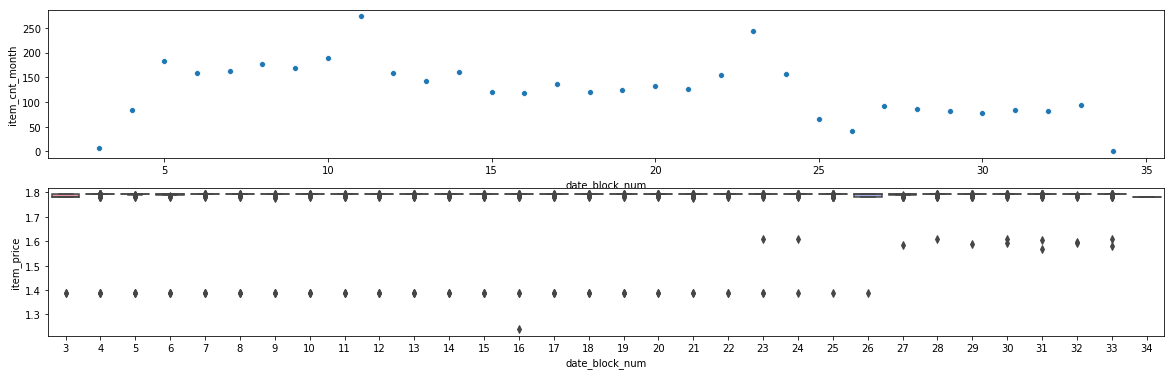

In [56]:
# feature exploration: item price and number of products sold by item id 20949
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[df_block['item_id'] == 20949].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[df_block['item_id'] == 20949], ax=axes[1])

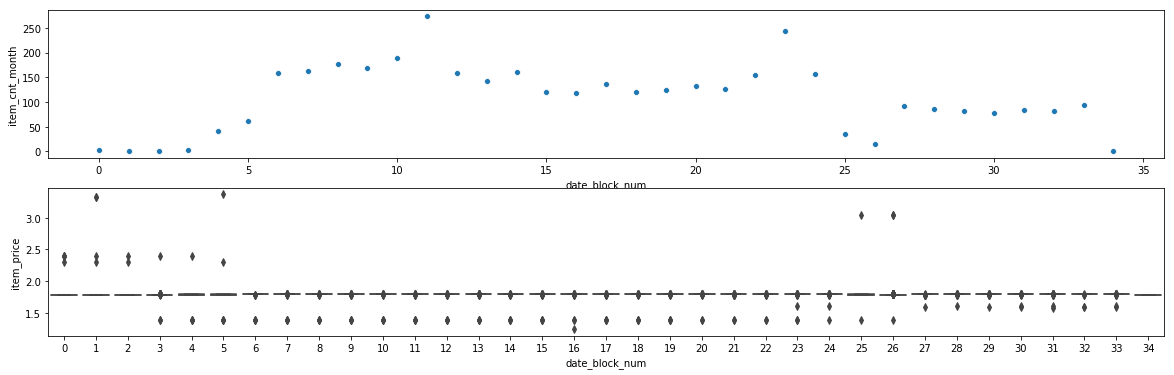

In [57]:
# feature exploration: item price and number of products sold by category id 71
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[df_block['item_category_id'] == 71].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[df_block['item_category_id'] == 71], ax=axes[1])

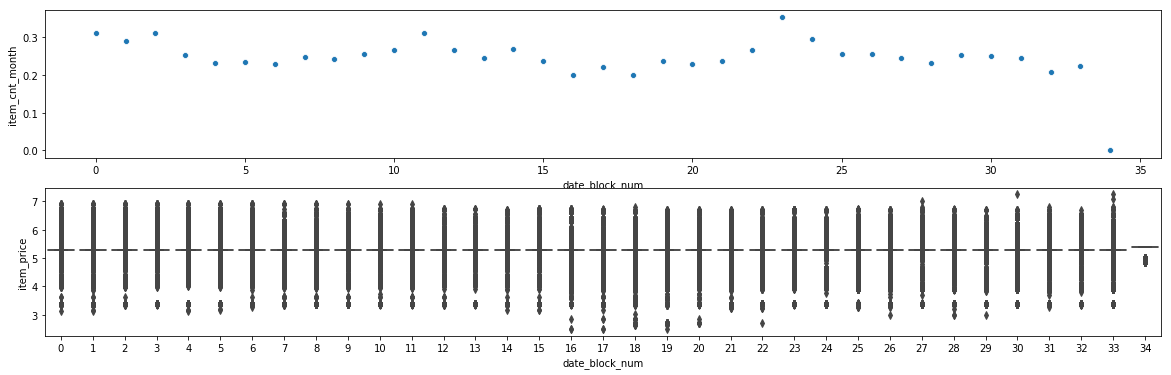

In [58]:
# feature exploration: item price and number of products sold by category id 40
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[df_block['item_category_id'] == 40].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[df_block['item_category_id'] == 40], ax=axes[1])

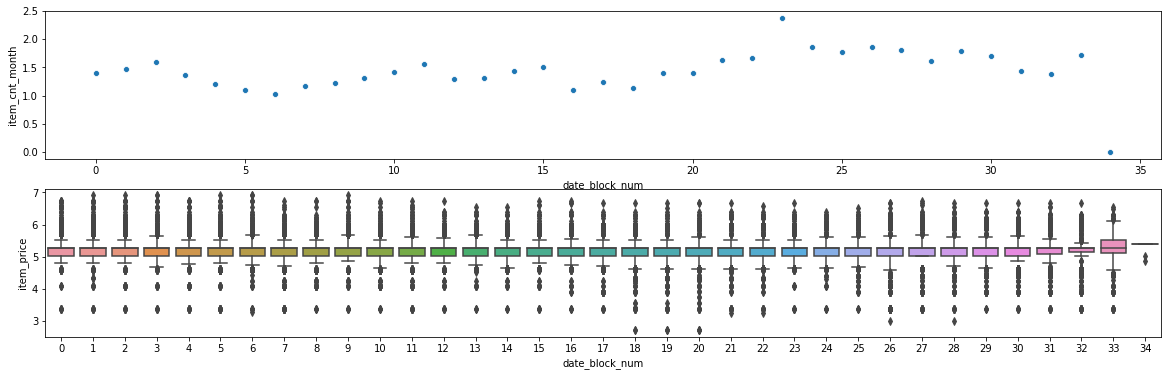

In [59]:
# feature exploration: item price and number of products sold by category id 40 and shop id 31
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[(df_block['item_category_id'] == 40) & (df_block['shop_id'] == 31)].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[(df_block['item_category_id'] == 40) & (df_block['shop_id'] == 31)], ax=axes[1])

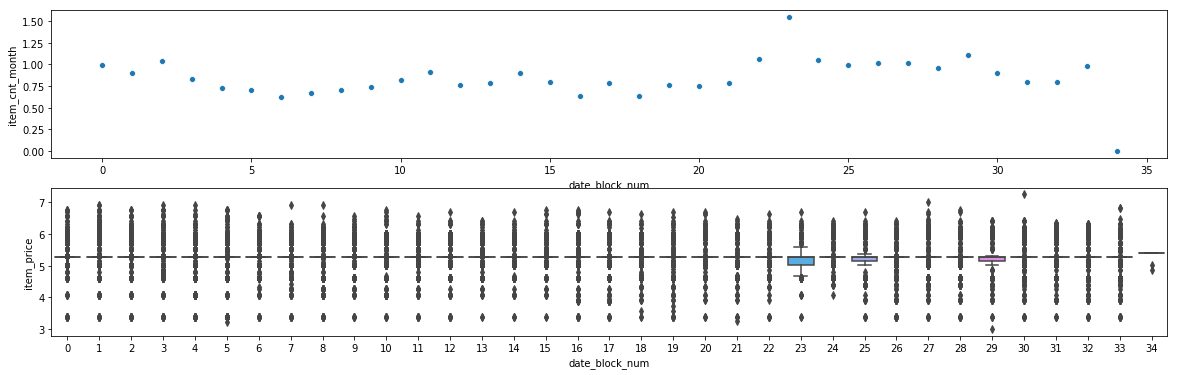

In [60]:
# feature exploration: item price and number of products sold by category id 40 and shop id 25
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[(df_block['item_category_id'] == 40) & (df_block['shop_id'] == 25)].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[(df_block['item_category_id'] == 40) & (df_block['shop_id'] == 25)], ax=axes[1])

In [61]:
# memory clean-up
df_block = df_block.drop(['item_name', 'item_category_name', 'shop_name', 'city', 'type', 'subtype'], axis=1)
gc.collect()

178

The exploratory data analysis resulting in,

* **Date:** It can be seen that there are correlations between item price and number of products sold with date.

In [62]:
# feature extraction: shifted features for item price
for i in [1]:
    shifted = df_block[['date_block_num', 'shop_id', 'item_id', 'item_price']].copy(deep=True)
    shifted.columns = ['date_block_num', 'shop_id','item_id', 'item_price_shift' + str(i)]
    shifted['date_block_num'] = shifted['date_block_num'] + i
    df_block = pd.merge(df_block, shifted, how='left', on=['date_block_num', 'shop_id', 'item_id'])

In [63]:
# feature extraction: statistic features for item price by item, category, shop and date block
df_block['item_price_by_category_date_mean'] = df_block.groupby(['date_block_num', 'item_category_id'])['item_price'].transform('mean').astype(np.float16)
df_block['item_price_by_shop_date_mean'] = df_block.groupby(['date_block_num', 'shop_id'])['item_price'].transform('mean').astype(np.float16)

In [64]:
# feature extraction: statistic shifted features for item price by category and date block
for i in [1]: df_block['item_price_by_category_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_category_id'])['item_price_shift' + str(i)].transform('mean').astype(np.float16)

In [65]:
# feature extraction: statistic shifted features for item price by shop and date block
for i in [1]: df_block['item_price_by_shop_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'shop_id'])['item_price_shift' + str(i)].transform('mean').astype(np.float16)

In [66]:
# feature extraction: statistic shifted features for delta item price by category and date block
for i in [1]: df_block['delta_item_price_by_category_date_mean_shift' + str(i)] = df_block['item_price_by_category_date_mean_shift' + str(i)] - df_block['item_price_by_category_date_mean']

In [67]:
# feature extraction: statistic shifted features for delta item price by shop and date block
for i in [1]: df_block['delta_item_price_by_shop_date_mean_shift' + str(i)] = df_block['item_price_by_shop_date_mean_shift' + str(i)] - df_block['item_price_by_shop_date_mean']

In [68]:
# feature extraction: set maximum and minimum limit for number of products sold
df_block['item_cnt_month'] = df_block['item_cnt_month'].clip(0 ,20)

In [69]:
# feature extraction: shifted features for number of products sold
for i in [1, 2, 3, 6, 12]:
    shifted = df_block[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']].copy(deep=True)
    shifted.columns = ['date_block_num', 'shop_id','item_id', 'item_cnt_month_shift' + str(i)]
    shifted['date_block_num'] = shifted['date_block_num'] + i
    df_block = pd.merge(df_block, shifted, how='left', on=['date_block_num', 'shop_id', 'item_id'])

In [70]:
# feature extraction: statistic shifted features for number of products sold by item and date block
for i in [1, 2, 3, 6, 12]: df_block['item_cnt_month_by_item_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_id'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

In [71]:
# feature extraction: statistic shifted features for number of products sold by category and date block
for i in [1]: df_block['item_cnt_month_by_category_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_category_id'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

In [72]:
# feature extraction: statistic shifted features for number of products sold by shop and date block
for i in [1, 2, 3, 6, 12]: df_block['item_cnt_month_by_shop_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'shop_id'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

In [73]:
# feature extraction: statistic shifted features for number of products sold by city and date block
for i in [1]: df_block['item_cnt_month_by_city_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'city_code'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

In [74]:
# feature extraction: statistic shifted features for number of products sold by type and date block
for i in [1]: df_block['item_cnt_month_by_type_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'type_code'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

In [75]:
# feature extraction: statistic shifted features for number of products sold by subtype and date block
for i in [1]: df_block['item_cnt_month_by_subtype_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'subtype_code'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

In [76]:
# feature extraction: statistic shifted features for number of products sold by item, shop and date block
for i in [1]: df_block['item_cnt_month_by_item_shop_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_id', 'shop_id'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

In [77]:
# feature extraction: statistic shifted features for number of products sold by category, shop and date block
for i in [1]: df_block['item_cnt_month_by_category_shop_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_category_id', 'shop_id'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

In [78]:
# feature extraction: statistic shifted features for number of products sold by shop, type and date block
for i in [1]: df_block['item_cnt_month_by_shop_type_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'shop_id', 'type_code'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

In [79]:
# feature extraction: statistic shifted features for number of products sold by shop, subtype and date block
for i in [1]: df_block['item_cnt_month_by_shop_subtype_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_category_id', 'shop_id', 'subtype_code'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

In [80]:
# feature extraction: first sale
df_block['first_sale_item'] = (df_block['date_block_num'] - df_block.groupby(['item_id'])['date_block_num'].transform('min')).astype(np.int16)
df_block['first_sale_item_shop'] = (df_block['date_block_num'] - df_block.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')).astype(np.int16)

In [81]:
# feature extraction: last sale
df_block['last_sale_item'] = (df_block['date_block_num'] - df_block.groupby(['item_id'])['date_block_num'].transform('max')).astype(np.int16)
df_block['last_sale_item_shop'] = (df_block['date_block_num'] - df_block.groupby(['item_id', 'shop_id'])['date_block_num'].transform('max')).astype(np.int16)

In [82]:
# feature extraction: drop first 12 months records
df_block = df_block[df_block['date_block_num'] > 11]

In [83]:
# feature extraction: fillna with 0
col_fillnas = df_block.columns[df_block.isna().any()].tolist()
df_block[col_fillnas] = df_block[col_fillnas].fillna(0)

In [84]:
# memory clean-up
col_floats = [col for col in df_block.columns if df_block[col].dtypes == 'float64']
col_ints = [col for col in df_block.columns if df_block[col].dtypes == 'int64']
df_block[col_floats] = df_block[col_floats].astype(np.float16)
df_block[col_ints] = df_block[col_ints].astype(np.int16)
gc.collect()

21

After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [85]:
# describe block dataframe
df_block.describe(include='all')

,date_block_num,shop_id,item_id,item_price,item_cnt_month,item_category_id,month,city_code,type_code,subtype_code,item_price_shift1,item_price_by_category_date_mean,item_price_by_shop_date_mean,item_price_by_category_date_mean_shift1,item_price_by_shop_date_mean_shift1,delta_item_price_by_category_date_mean_shift1,delta_item_price_by_shop_date_mean_shift1,item_cnt_month_shift1,item_cnt_month_shift2,item_cnt_month_shift3,item_cnt_month_shift6,item_cnt_month_shift12,item_cnt_month_by_item_date_mean_shift1,item_cnt_month_by_item_date_mean_shift2,item_cnt_month_by_item_date_mean_shift3,item_cnt_month_by_item_date_mean_shift6,item_cnt_month_by_item_date_mean_shift12,item_cnt_month_by_category_date_mean_shift1,item_cnt_month_by_shop_date_mean_shift1,item_cnt_month_by_shop_date_mean_shift2,item_cnt_month_by_shop_date_mean_shift3,item_cnt_month_by_shop_date_mean_shift6,item_cnt_month_by_shop_date_mean_shift12,item_cnt_month_by_city_date_mean_shift1,item_cnt_month_by_type_date_mean_shift1,item_cnt_month_by_subtype_date_mean_shift1,item_cnt_month_by_item_shop_date_mean_shift1,item_cnt_month_by_category_shop_date_mean_shift1,item_cnt_month_by_shop_type_date_mean_shift1,item_cnt_month_by_shop_subtype_date_mean_shift1,first_sale_item,first_sale_item_shop,last_sale_item,last_sale_item_shop
count,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6619864.0,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6619864.0,6619864.0,6619864.0,6619864.0,6619864.0,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6619864.0,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06,6.619864e+06
mean,2.198128e+01,3.189521e+01,1.126466e+04,NaN,NaN,4.496229e+01,5.118828e+00,1.554849e+01,1.099756e+01,1.952673e+01,NaN,NaN,NaN,NaN,NaN,-2.449036e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.306787e+01,1.225860e+01,-7.968478e+00,-7.371860e+00
std,6.460157e+00,1.727561e+01,6.272158e+03,0.000000e+00,0.0,1.573286e+01,3.390552e+00,7.998976e+00,2.976279e+00,2.085084e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.219604e-02,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,8.442771e+00,8.390037e+00,6.032994e+00,5.888674e+00
min,1.200000e+01,2.000000e+00,0.000000e+00,4.055176e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.763672e+00,5.882812e+00,0.000000e+00,0.000000e+00,-5.390625e-01,-1.328125e-01,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01,-2.200000e+01
25%,1.600000e+01,1.700000e+01,5.681000e+03,5.558594e+00,0.0,3.700000e+01,2.000000e+00,1.100000e+01,1.100000e+01,2.000000e+00,5.277344e+00,5.558594e+00,5.968750e+00,5.558594e+00,5.972656e+00,-3.906250e-03,-2.343750e-02,0.0,0.0,0.0,0.0,0.0,2.040100e-02,2.000427e-02,0.000000e+00,0.000000e+00,0.000000e+00,1.785889e-01,2.094727e-01,2.191162e-01,2.254639e-01,2.462158e-01,2.814941e-01,2.126465e-01,2.220459e-01,1.809082e-01,0.0,5.661011e-02,1.218872e-01,5.661011e-02,6.000000e+00,5.000000e+00,-1.200000e+01,-1.200000e+01
50%,2.200000e+01,3.300000e+01,1.137300e+04,5.761719e+00,0.0,4.000000e+01,5.000000e+00,1.400000e+01,1.100000e+01,9.000000e+00,5.593750e+00,5.761719e+00,6.097656e+00,5.761719e+00,6.050781e+00,0.000000e+00,-7.812500e-03,0.0,0.0,0.0,0.0,0.0,8.160400e-02,8.160400e-02,8.001709e-02,6.524658e-02,2.221680e

In [86]:
# verify dtypes object
df_block.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6619864 entries, 4478844 to 11098707
Data columns (total 44 columns):
date_block_num                                      int16
shop_id                                             int16
item_id                                             int16
item_price                                          float16
item_cnt_month                                      float16
item_category_id                                    int16
month                                               int16
city_code                                           int16
type_code                                           int16
subtype_code                                        int16
item_price_shift1                                   float16
item_price_by_category_date_mean                    float16
item_price_by_shop_date_mean                        float16
item_price_by_category_date_mean_shift1             float16
item_price_by_shop_date_mean_shift1                 floa

> **Analyze and identify patterns by visualizations**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot very conveniently as follows.

The Pearson Correlation plot can tell us the correlation between features with one another. If there is no strongly correlated between features, this means that there isn't much redundant or superfluous data in our training data. This plot is also useful to determine which features are correlated to the observed value.

The pairplots is also useful to observe the distribution of the training data from one feature to the other.

The pivot table is also another useful method to observe the impact between features.

> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [87]:
# perform train-test (validate) split
x_train = df_block[df_block['date_block_num'] < 33].drop(['item_cnt_month'], axis=1)
y_train = df_block.loc[df_block['date_block_num'] < 33]['item_cnt_month']
x_validate = df_block[df_block['date_block_num'] == 33].drop(['item_cnt_month'], axis=1)
y_validate = df_block.loc[df_block['date_block_num'] == 33]['item_cnt_month']

In [88]:
# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(booster='gbtree', learning_rate=0.3, n_estimators=200, objective='reg:linear', random_state=58,
                                colsample_bytree=0.8, max_depth=8, reg_alpha=0, reg_lambda=1, subsample=0.8)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, early_stopping_rounds=10, eval_set=[(x_validate, y_validate)], verbose=False,
                 callbacks=[xgb.callback.print_evaluation(period=10)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.03313
[10]	validation_0-rmse:0.832248
[20]	validation_0-rmse:0.841974
xgboost regression
  root mean squared error: 0.8146


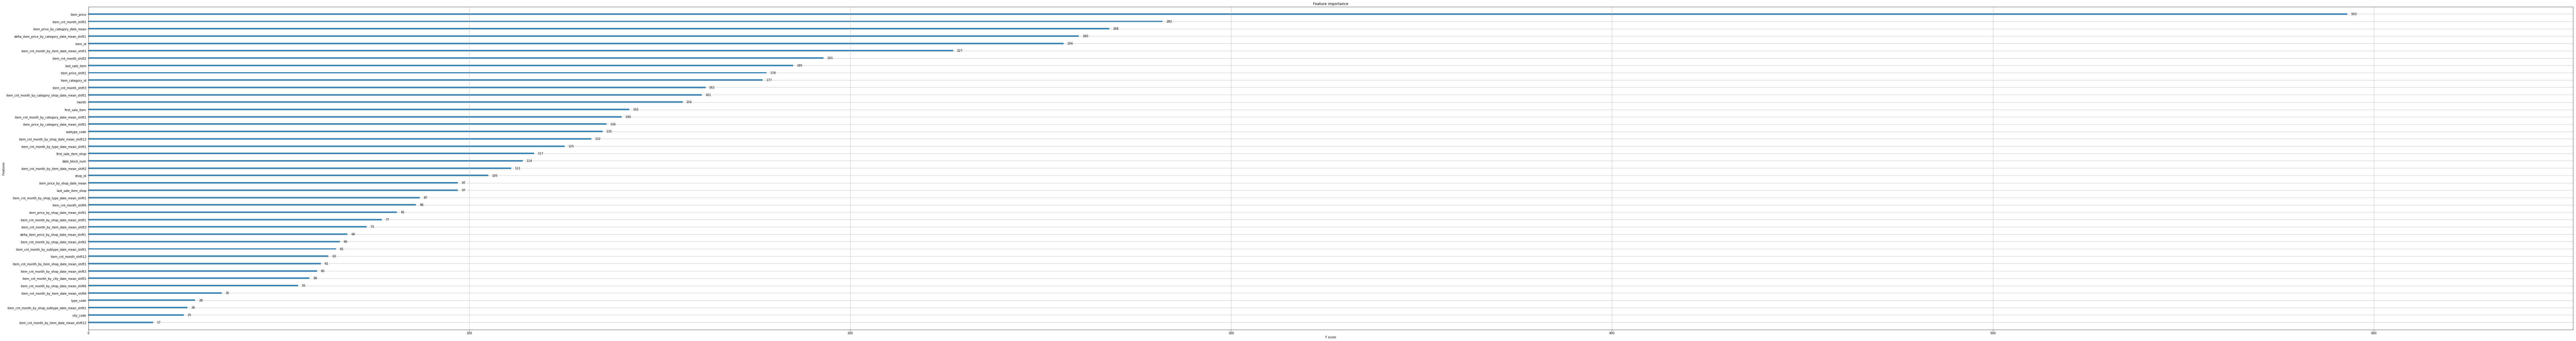

In [89]:
# plot the feature importances
fig, axes = plt.subplots(figsize=(150 , 20))
xgb.plot_importance(model_xgbreg, ax=axes)

In [90]:
# memory clean-up
del x_train, x_validate, y_train, y_validate

> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [91]:
# feature extraction: fix the duplicated shop id
df_test.loc[df_test['shop_id'] == 0, 'shop_id'] = 57
df_test.loc[df_test['shop_id'] == 1, 'shop_id'] = 58
df_test.loc[df_test['shop_id'] == 11, 'shop_id'] = 10

In [92]:
# model selection
final_model = model_xgbreg

# prepare testing data and compute the observed value
x_test = df_block[df_block['date_block_num'] == 34].drop(['item_cnt_month'], axis=1)
y_test = pd.DataFrame({'item_cnt_month': final_model.predict(x_test).clip(0 ,20), 'shop_id': x_test['shop_id'], 'item_id': x_test['item_id']}, index=x_test.index)
y_test = pd.merge(y_test, df_test[['ID', 'shop_id', 'item_id']], how='left', on=['shop_id', 'item_id'])

In [93]:
# summit the results
out = pd.DataFrame({'ID': y_test['ID'], 'item_cnt_month': y_test['item_cnt_month']})
out.to_csv('submission.csv', index=False)